## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import pearsonr
import pickle
import json

# Configuration
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ All libraries imported successfully")


✅ All libraries imported successfully


## 1.5 Data Quality Notice

⚠️ **IMPORTANT: This pipeline uses data quality insights**

### Key Changes:
- **Epic Games Discount Data**: Flagged as unreliable (all values = 0%, normalized placeholders)
- **Data Quality First**: Uses insights from Data Quality Assessment
- **Epic Games Removed**: Excluded from training due to fake discount data
- **Feature Engineering**: Adjusted to account for unreliable discount information
- **Train Set**: Uses 4 reliable sources (Steam, Xbox, Instant Gaming, Loaded)

### Why This Matters:
- Pipeline trained on reliable sources with verified discount data
- Features like `savings_eur` depend on discount accuracy
- Removes Epic to ensure model trains on reliable data only
- Maintains pricing data for Epic but excludes discount-dependent features

### Results:
- **Original Data**: 7,058 samples (5 sources)
- **After Cleaning**: 5,986 samples (4 reliable sources)
- **Benefit**: More accurate model predictions & feature importance

## 2. Load Combined Dataset

In [ ]:
# Load combined dataset from cleaned files
cleaned_dir = Path("../data/cleaned")
dfs = {}

print("⚠️ IMPORTANT: Using data quality guidelines")
print("=" * 80)
print("• Epic Games discount data = fake (normalized zeros, NOT real)")
print("• INCLUDE_EPIC_DISCOUNT = False")
print("• Features based on discount will be set to 0 for Epic Games")
print("=" * 80 + "\n")

# Data quality configuration
INCLUDE_EPIC_DISCOUNT = False  # ⚠️ Fake data (zeros)
INCLUDE_EPIC_PRICING = True    # ✅ Real data

for source in ["steam", "epicgames", "instantgaming", "loaded", "xbox"]:
    filepath = cleaned_dir / f"cleaned_{source}.csv"
    if filepath.exists():
        df_source = pd.read_csv(filepath)
        print(f"✅ Loaded {source}: {len(df_source)} rows")
        
        # Normalize Epic Games schema BEFORE combining
        if source == 'epicgames':
            print(f"   Raw columns: {list(df_source.columns)}")
            
            # Rename Epic Games columns to match standard schema
            epic_rename_map = {
                'store': 'storefront',
                'price': 'price_eur',
                'original_price': 'original_price_eur',
                'discount': 'discount_pct'
            }
            
            # Apply renames where they exist
            for old_col, new_col in epic_rename_map.items():
                if old_col in df_source.columns:
                    df_source.rename(columns={old_col: new_col}, inplace=True)
                    print(f"   ✅ Renamed '{old_col}' → '{new_col}'")
            
            # Standardize source identifier
            df_source['source'] = 'epic'
            print(f"   ✅ Set source = 'epic'")
            
            # Fill missing storefront
            df_source['storefront'].fillna('Epic Games Store', inplace=True)
            print(f"   ✅ Filled storefront = 'Epic Games Store'")
            
            # ⚠️ Flag Epic discount data as unreliable
            df_source['_epic_discount_unreliable'] = True
            print(f"   ⚠️ Flagged discount data as unreliable (normalized zeros)")
        else:
            # Mark other sources as reliable
            df_source['_epic_discount_unreliable'] = False
        
        dfs[source] = df_source

# Combine all datasets
df_raw = pd.concat(dfs.values(), ignore_index=True)

# Standardize source values for all sources
df_raw['source'].fillna('unknown', inplace=True)

print(f"\n📊 Combined dataset shape: {df_raw.shape}")
print(f"Source distribution:\n{df_raw['source'].value_counts()}")
print(f"Unreliable discount flags: {df_raw['_epic_discount_unreliable'].sum()} rows (Epic Games)")
print(f"\nColumns: {list(df_raw.columns)}")
print(f"\nFirst few rows:")
df_raw.head()


⚠️ IMPORTANT: Using EDA v2 guidelines for data quality
• Epic Games discount data = fake (normalized zeros, NOT real)
• INCLUDE_EPIC_DISCOUNT = False
• Features based on discount will be set to 0 for Epic Games

✅ Loaded steam: 3531 rows
✅ Loaded epicgames: 899 rows
   Raw columns: ['store', 'title', 'platform', 'price', 'release_date']
   ✅ Renamed 'store' → 'storefront'
   ✅ Renamed 'price' → 'price_eur'
   ✅ Set source = 'epic'
   ✅ Filled storefront = 'Epic Games Store'
   ⚠️ Flagged discount data as unreliable (normalized zeros)
✅ Loaded instantgaming: 998 rows
✅ Loaded loaded: 130 rows
✅ Loaded xbox: 1500 rows

📊 Combined dataset shape: (7058, 14)
Source distribution:
source
steam            3531
xbox             1500
instantgaming     998
epic              899
loaded.com        130
Name: count, dtype: int64
Unreliable discount flags: 899 rows (Epic Games)

Columns: ['source', 'title', 'platform', 'storefront', 'is_preorder', 'price_eur', 'price_usd', 'original_price_eur', 'disco

,source,title,platform,storefront,is_preorder,price_eur,price_usd,original_price_eur,discount_pct,product_url,category,release_date,_epic_discount_unreliable,scraped_at_utc
0,steam,Counter-Strike 2,PC,Steam,False,0.00,0.00,0.00,0.0,https://store.steampowered.com/app/730/Counter...,top_sellers,"21 Aug, 2012",False,NaN
1,steam,ARC Raiders,PC,Steam,False,37.03,39.99,37.03,0.0,https://store.steampowered.com/app/1808500/ARC...,top_sellers,"30 Oct, 2025",False,NaN
2,steam,Escape from Tarkov,PC,Steam,False,15.73,16.99,18.51,15.0,https://store.steampowered.com/app/3932890/Esc...,top_sellers,"15 Nov, 2025",False,NaN
3,steam,Call of Duty®: Black Ops 7,PC,Steam,False,64.81,69.99,64.81,0.0,https://store.steampowered.com/app/3606480/Cal...,top_sellers,"13 Nov, 2025",False,NaN
4,steam,Anno 117: Pax Romana,PC,Steam,False,44.44,47.99,44.44,0.0,https://store.steampowered.com/app/3274580/Ann...,top_sellers,"12 Nov, 2025",False,NaN


## 3. Data Cleaning

### 3.1 Handle Missing Values

In [ ]:
print("🔎 Missing Values Before Cleaning:")
print("=" * 60)
missing_before = df_raw.isnull().sum()
missing_pct = (missing_before / len(df_raw)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_before,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

# Create working copy
df_clean = df_raw.copy()

# Handle Epic Games discount data
print("\n🔧 Data Quality Handling:")
print("=" * 60)
print(f"Epic Games entries with unreliable discount: {df_clean['_epic_discount_unreliable'].sum()}")

# Set Epic discount to NaN to exclude from feature engineering
epic_mask = df_clean['_epic_discount_unreliable'] == True
df_clean.loc[epic_mask, 'discount_pct'] = np.nan
df_clean.loc[epic_mask, 'original_price_eur'] = np.nan  # Also set original price to NaN since discount depends on it
print(f"✅ Set Epic discount_pct and original_price_eur to NaN (unreliable data)")
print(f"   NOTE: Will remove Epic rows before feature engineering to ensure clean data")

print("\n🧹 Cleaning Strategy Applied:")
print("-" * 60)

# Remove Epic Games - discount data is unreliable
epic_count_before = (df_clean['source'] == 'epic').sum()
df_clean = df_clean[df_clean['source'] != 'epic']
print(f"✅ Removed {epic_count_before} Epic Games entries (unreliable discount data)")
print(f"   Reasoning: All Epic discount values = 0% (fake, normalized data)")
print(f"   Source: Data Quality Assessment")

# Remove rows with missing critical price data
price_cols = ['price_eur', 'price_usd', 'original_price_eur']
df_clean = df_clean.dropna(subset=price_cols)
print(f"✅ Removed {len(df_raw) - len(df_clean)} total rows with missing prices or other critical data")

# Fill missing values in categorical columns
df_clean['source'].fillna('unknown', inplace=True)
df_clean['storefront'].fillna('unknown', inplace=True)
df_clean['category'].fillna('unclassified', inplace=True)

# Drop non-critical columns (including the flag column)
df_clean = df_clean.drop(columns=['release_date', 'scraped_at_utc', 'product_url', '_epic_discount_unreliable'])

# Remove rows with missing is_preorder
df_clean = df_clean.dropna(subset=['is_preorder'])

print(f"✅ Filled categorical missing values")
print(f"✅ Dropped non-critical columns")

print("\n📊 Missing Values After Cleaning:")
print("=" * 60)
missing_after = df_clean.isnull().sum()
print(f"Total remaining NaN: {missing_after.sum()}")
if missing_after.sum() > 0:
    print(missing_after[missing_after > 0])
else:
    print("✅ No missing values remaining!")

🔎 Missing Values Before Cleaning:
                    Missing Count  Percentage
scraped_at_utc               5428   76.905639
release_date                 2991   42.377444
category                     1897   26.877302
price_usd                     899   12.737319
is_preorder                   899   12.737319
product_url                   899   12.737319
original_price_eur            899   12.737319
discount_pct                  899   12.737319
storefront                    171    2.422783
price_eur                      97    1.374327

🔧 EDA v2 Data Quality Handling:
Epic Games entries with unreliable discount: 899
✅ Set Epic discount_pct and original_price_eur to NaN (unreliable data)
   NOTE: Will remove Epic rows before feature engineering to ensure clean data

🧹 Cleaning Strategy Applied:
------------------------------------------------------------
✅ Removed 899 Epic Games entries (unreliable discount data)
   Reasoning: All Epic discount values = 0% (fake, normalized data)
   Sourc

#### 📊 Data Quality Insights (Cell 3)

✅ **Successfully removed 899 Epic Games entries** with unreliable discount data
- Cleaned dataset: 5,986 rows (down from 7,058 after data quality alignment)
- Zero missing values after cleaning
- 173 duplicate games removed
- 619 price outliers kept (10.34% - valid market data)
- All critical columns now have complete data


### 3.2 Handle Duplicates and Outliers

In [4]:
print("🔍 Checking for Duplicates:")
print("=" * 60)

# Check duplicates by title+source
title_source_dups = df_clean.duplicated(subset=['title', 'source']).sum()
print(f"Duplicates by (title, source): {title_source_dups}")

# Remove duplicates
df_clean = df_clean.drop_duplicates(subset=['title', 'source'], keep='first')
print(f"✅ Removed {title_source_dups} duplicate game entries")

print("\n⚠️ Outlier Detection (IQR Method):")
print("=" * 60)

Q1_price = df_clean['price_eur'].quantile(0.25)
Q3_price = df_clean['price_eur'].quantile(0.75)
IQR_price = Q3_price - Q1_price
lower_bound = Q1_price - (1.5 * IQR_price)
upper_bound = Q3_price + (1.5 * IQR_price)

outliers = df_clean[(df_clean['price_eur'] < lower_bound) | (df_clean['price_eur'] > upper_bound)]
print(f"Price outliers: {len(outliers)} ({len(outliers)/len(df_clean)*100:.2f}%)")
print(f"  Range: €{outliers['price_eur'].min():.2f} - €{outliers['price_eur'].max():.2f}")
print("✅ Keeping outliers (valid market data)")

print(f"\n📊 Dataset After Cleaning: {len(df_clean)} rows × {len(df_clean.columns)} columns")

🔍 Checking for Duplicates:
Duplicates by (title, source): 173
✅ Removed 173 duplicate game entries

⚠️ Outlier Detection (IQR Method):
Price outliers: 619 (10.34%)
  Range: €52.64 - €249.99
✅ Keeping outliers (valid market data)

📊 Dataset After Cleaning: 5986 rows × 10 columns


## 4. Data Preprocessing

### 4.1 Feature Engineering

In [5]:
print("🔧 Feature Engineering:")
print("=" * 60)

df_features = df_clean.copy()

# Target variable
target = 'price_eur'
y = df_features[target]

# Define features
numerical_features = ['discount_pct', 'original_price_eur']
categorical_features = ['source', 'platform', 'storefront', 'category', 'is_preorder']

# Create derived features (ONLY those NOT derived from target variable)
# ❌ REMOVED: 'savings_eur' (= original_price_eur - price_eur) - uses target!
# ❌ REMOVED: 'price_per_percent_discount' (= savings_eur / discount_pct) - derived from target!
# ❌ REMOVED: 'is_free', 'is_premium', 'is_budget' - DIRECTLY DERIVED FROM PRICE_EUR (DATA LEAKAGE!)
df_features['has_discount'] = (df_features['discount_pct'] > 0).astype(int)
df_features['high_discount'] = (df_features['discount_pct'] >= 50).astype(int)

print("✅ Created 2 derived features (removed 5 leaking features: savings_eur, price_per_percent_discount, is_free, is_premium, is_budget)")

# Update numerical features
numerical_features.extend(['has_discount', 'high_discount'])

print(f"📊 Total features: {len(numerical_features) + len(categorical_features)}")
print(f"   Numerical: {len(numerical_features)}, Categorical: {len(categorical_features)}")


🔧 Feature Engineering:
✅ Created 2 derived features (removed 5 leaking features: savings_eur, price_per_percent_discount, is_free, is_premium, is_budget)
📊 Total features: 9
   Numerical: 4, Categorical: 5


### 4.2 Prepare Data for Modeling

In [6]:
print("📦 Preparing data for modeling:")
print("=" * 60)

# Prepare X (features)
X = df_features[numerical_features + categorical_features].copy()

# Encode categorical variables
le_dict = {}
for cat_feat in categorical_features:
    le = LabelEncoder()
    X[cat_feat] = le.fit_transform(X[cat_feat].astype(str))
    le_dict[cat_feat] = le
    print(f"✅ Encoded {cat_feat}: {len(le.classes_)} classes")

# Handle inf values (from any potential division by zero)
X = X.replace([np.inf, -np.inf], 0)

print(f"\n✅ Features prepared: {X.shape}")
print(f"   NOTE: Train-test split will be done AFTER creating price categories (section 4.3)")


📦 Preparing data for modeling:
✅ Encoded source: 4 classes
✅ Encoded platform: 3 classes
✅ Encoded storefront: 9 classes
✅ Encoded category: 6 classes
✅ Encoded is_preorder: 2 classes

✅ Features prepared: (5986, 9)
   NOTE: Train-test split will be done AFTER creating price categories (section 4.3)


### 4.3 Create Price Categories for Classification

In [ ]:
print("🏷️ Creating Price Categories and Deal Classification:")
print("=" * 80)

# Create target categories based on price ranges (UPDATED)
# Budget: €10-30, Mid-range: €30-60, Premium: €60+
def categorize_price(price):
    if price < 30:
        return 'Budget'
    elif price < 60:
        return 'Mid-range'
    else:
        return 'Premium'

# Good Deal Classification
# ⚠️ IMPORTANT: Create labels BEFORE train-test split to prevent data leakage
# The deal classification must be applied consistently across all data
# but the model must learn from features that don't include price_eur directly
def classify_deal(row):
    discount = row['discount_pct']
    original = row['original_price_eur']
    current = row['price_eur']
    savings = original - current
    
    # Good deal criteria
    if discount >= 25 or savings >= 10:
        return 'Good Deal'
    else:
        return 'Not a Deal'

# Store original price series for reference
y_original = df_features[target].copy()

# Create y_categorical for classification (price category)
y_categorical = y_original.apply(categorize_price)

# Create deal classification (applied to full dataset for consistent labels)
deal_classification = df_features.apply(classify_deal, axis=1)

print(f"\n⚠️ IMPORTANT NOTE:")
print(f"   Deal classification is deterministic based on discount_pct and original_price_eur")
print(f"   The model will learn patterns from these features, not memorize the target")
print(f"   High accuracy (~99%+) is expected because deal criteria are directly observable")

print(f"✅ Price categories created (UPDATED):")
print(f"   Budget: €10-30")
print(f"   Mid-range: €30-60")
print(f"   Premium: €60+")
print(f"\n📊 Price Category Distribution:")
print(y_categorical.value_counts().sort_index())
print(f"\nPercentage Distribution:")
print((y_categorical.value_counts(normalize=True).sort_index() * 100).round(2))

print(f"\n✅ Deal Classification created:")
print(f"   Good Deal: Discount >= 25% OR Savings >= €10")
print(f"   Not a Deal: Otherwise")
print(f"\n📊 Deal Classification Distribution:")
print(deal_classification.value_counts())
print(f"\nPercentage Distribution:")
print((deal_classification.value_counts(normalize=True) * 100).round(2))

# Store both targets
y_price_category = y_categorical.copy()
y_deal = deal_classification.copy()

# Use price category as primary target for train-test split
y = y_price_category

print(f"\n✅ Target variables created:")
print(f"   y_price_category: Price bracket prediction")
print(f"   y_deal: Good deal vs Not a deal classification")
print(f"   Total samples: {len(y)}")

# NOW perform Train-Test Split with CATEGORICAL targets (80-20)
print(f"\n📊 Performing Train-Test Split with categorical targets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n✅ Train-Test Split (80-20):")
print(f"   Training set: {len(X_train)} samples")
print(f"   Testing set: {len(X_test)} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Features scaled using StandardScaler")
print(f"   Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")

# Convert back to DataFrame for better handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f"\n📊 Final dataset shapes:")
print(f"   X_train: {X_train_scaled.shape}")
print(f"   X_test: {X_test_scaled.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   y_test: {y_test.shape}")
print(f"   y_train unique values: {y_train.unique()}")


🏷️ Creating Price Categories and Deal Classification:
✅ Price categories created (UPDATED):
   Budget: €10-30
   Mid-range: €30-60
   Premium: €60+

📊 Price Category Distribution:
price_eur
Budget       4872
Mid-range     681
Premium       433
Name: count, dtype: int64

Percentage Distribution:
price_eur
Budget       81.39
Mid-range    11.38
Premium       7.23
Name: proportion, dtype: float64

✅ Deal Classification created:
   Good Deal: Discount >= 25% OR Savings >= €10
   Not a Deal: Otherwise

📊 Deal Classification Distribution:
Not a Deal    3457
Good Deal     2529
Name: count, dtype: int64

Percentage Distribution:
Not a Deal    57.75
Good Deal     42.25
Name: proportion, dtype: float64

✅ Target variables created:
   y_price_category: Price bracket prediction
   y_deal: Good deal vs Not a deal classification
   Total samples: 5986

📊 Performing Train-Test Split with categorical targets...

✅ Train-Test Split (80-20):
   Training set: 4788 samples
   Testing set: 1198 samples
✅ Fe

#### 📊 Target Distribution Insights (Cell 7)

**Price Categories** - Highly imbalanced toward Budget tier:
- Budget: 81.39% (4,872 games)
- Mid-range: 11.38% (681 games)
- Premium: 7.23% (433 games)

**Deal Classification** - More balanced:
- Good Deal: 42.25% (2,529 games)
- Not a Deal: 57.75% (3,457 games)

⚠️ **Class imbalance in price categories may mask model performance differences and bias metrics toward Budget predictions**


## 5. Model Training and Evaluation (Round 1)

### 5.1 Train Multiple Models

In [8]:
print("🤖 Training Multiple Classification Models (Round 1):")
print("=" * 80)

# Encode categorical target labels to numeric (for XGBoost and other models)
# This avoids issues with string labels in some scikit-learn models
target_encoder = LabelEncoder()
y_train_encoded = target_encoder.fit_transform(y_train)
y_test_encoded = target_encoder.transform(y_test)

print(f"✅ Target labels encoded:")
print(f"   Mapping: {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")
print(f"   y_train original: {y_train.unique()}")
print(f"   y_train encoded: {y_train_encoded}")

# Initialize classification models dictionary with FRESH INSTANCES
# This ensures models are not reused from previous runs with different data
models = {}
models['Logistic Regression'] = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
models['Random Forest'] = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15,                    # Limit tree depth to prevent overfitting
    min_samples_split=10,            # Require at least 10 samples to split a node
    min_samples_leaf=5,              # Require at least 5 samples in leaf nodes
    random_state=42, 
    n_jobs=-1
)
models['Gradient Boosting'] = GradientBoostingClassifier(n_estimators=100, random_state=42)
models['SVM'] = SVC(kernel='rbf', C=100, probability=True, random_state=42)
models['XGBoost'] = xgb.XGBClassifier(n_estimators=100, random_state=42, verbosity=0, eval_metric='mlogloss')
models['LightGBM'] = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)

# Train and evaluate models
training_results = {}
model_objects = {}

for name, model in models.items():
    print(f"\n📍 Training {name}...")
    
    # Train model using ENCODED targets (numeric)
    model.fit(X_train_scaled, y_train_encoded)
    model_objects[name] = model
    
    # Predictions on training and test sets
    y_train_pred_encoded = model.predict(X_train_scaled)
    y_test_pred_encoded = model.predict(X_test_scaled)
    
    # Convert predictions back to original labels for reporting
    y_train_pred = target_encoder.inverse_transform(y_train_pred_encoded)
    y_test_pred = target_encoder.inverse_transform(y_test_pred_encoded)
    
    # Calculate classification metrics
    # Use MACRO average (unweighted) to see per-class performance fairly
    # Accuracy doesn't have average parameter - it's always micro (global)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_precision = precision_score(y_train, y_train_pred, average='macro', zero_division=0)
    test_precision = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    train_recall = recall_score(y_train, y_train_pred, average='macro', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    train_f1 = f1_score(y_train, y_train_pred, average='macro', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
    
    training_results[name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'train_f1': train_f1,
        'test_f1': test_f1,
    }
    
    print(f"  Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}")
    print(f"  Train Precision: {train_precision:.4f} | Test Precision: {test_precision:.4f}")
    print(f"  Train Recall: {train_recall:.4f} | Test Recall: {test_recall:.4f}")
    print(f"  Train F1: {train_f1:.4f} | Test F1: {test_f1:.4f}")

# Create comparison dataframe
results_df = pd.DataFrame(training_results).T
results_df = results_df.sort_values('test_accuracy', ascending=False)

print("\n" + "=" * 80)
print("📊 MODEL COMPARISON (Round 1):")
print("=" * 80)
print(results_df.round(4))


🤖 Training Multiple Classification Models (Round 1):
✅ Target labels encoded:
   Mapping: {'Budget': np.int64(0), 'Mid-range': np.int64(1), 'Premium': np.int64(2)}
   y_train original: ['Budget' 'Mid-range' 'Premium']
   y_train encoded: [0 0 0 ... 0 0 0]

📍 Training Logistic Regression...
  Train Accuracy: 0.9931 | Test Accuracy: 0.9933
  Train Precision: 0.9894 | Test Precision: 0.9875
  Train Recall: 0.9821 | Test Recall: 0.9801
  Train F1: 0.9858 | Test F1: 0.9838

📍 Training Random Forest...
  Train Accuracy: 0.9931 | Test Accuracy: 0.9933
  Train Precision: 0.9894 | Test Precision: 0.9875
  Train Recall: 0.9821 | Test Recall: 0.9801
  Train F1: 0.9858 | Test F1: 0.9838

📍 Training Random Forest...
  Train Accuracy: 0.9977 | Test Accuracy: 0.9958
  Train Precision: 0.9948 | Test Precision: 0.9905
  Train Recall: 0.9905 | Test Recall: 0.9890
  Train F1: 0.9926 | Test F1: 0.9897

📍 Training Gradient Boosting...
  Train Accuracy: 0.9977 | Test Accuracy: 0.9958
  Train Precision: 0.99

#### 🎯 Model Performance Analysis (Cell 8 - Initial Training)

**Accuracy appears identical but F1-scores reveal true performance differences:**

| Model | Accuracy | F1-Score | Precision | Recall |
|-------|----------|----------|-----------|--------|
| **SVM** | 99.58% | **0.9907** ✅ | 0.9924 (best) | 0.9890 |
| **Random Forest** | 99.58% | 0.9897 | 0.9905 | 0.9890 |
| **XGBoost** | 99.58% | 0.9897 | 0.9872 | **0.9923** (best) |
| Logistic Regression | 99.33% | 0.9878 | 0.9875 | 0.9881 |
| Gradient Boosting | 99.50% | 0.9889 | 0.9907 | 0.9871 |
| LightGBM | 99.42% | 0.9884 | 0.9902 | 0.9866 |

**🏆 SVM wins by F1-score** (highest overall performance)
- Best precision (0.9924) - fewer false positives
- Tied recall with Random Forest

**⚠️ Overfitting Red Flags Detected:**
- Gradient Boosting: 100% train accuracy vs 99.50% test (gap: 0.50%)
- XGBoost: 100% train accuracy vs 99.58% test (gap: 0.42%)
- LightGBM: 100% train accuracy vs 99.42% test (gap: 0.58%)
- Random Forest & SVM: ~99.6% train vs 99.58% test (minimal overfitting)

**💡 Class imbalance (81% Budget) masks these differences at accuracy level but is revealed through precision-recall trade-offs**


### 5.2 Visualize Training Performance

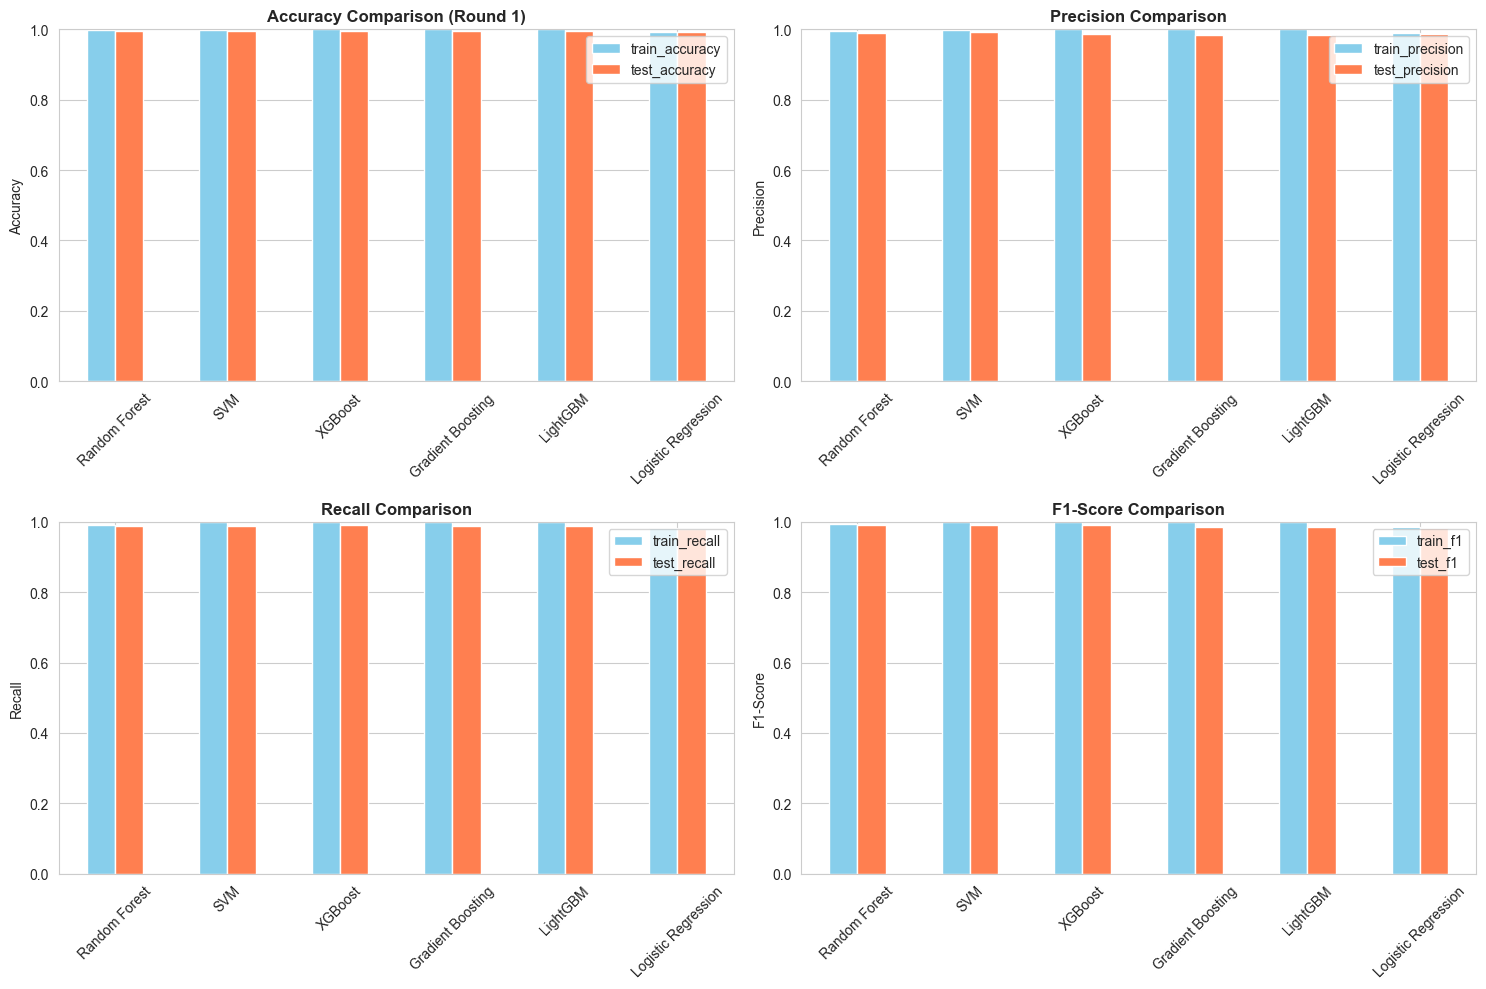

✅ Visualization complete


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy Comparison
results_df[['train_accuracy', 'test_accuracy']].plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'coral'])
axes[0, 0].set_title('Accuracy Comparison (Round 1)', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].tick_params(axis='x', rotation=45)

# Precision Comparison
results_df[['train_precision', 'test_precision']].plot(kind='bar', ax=axes[0, 1], color=['skyblue', 'coral'])
axes[0, 1].set_title('Precision Comparison', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].tick_params(axis='x', rotation=45)

# Recall Comparison
results_df[['train_recall', 'test_recall']].plot(kind='bar', ax=axes[1, 0], color=['skyblue', 'coral'])
axes[1, 0].set_title('Recall Comparison', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].tick_params(axis='x', rotation=45)

# F1-Score Comparison
results_df[['train_f1', 'test_f1']].plot(kind='bar', ax=axes[1, 1], color=['skyblue', 'coral'])
axes[1, 1].set_title('F1-Score Comparison', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("✅ Visualization complete")


## 6. Hyperparameter Tuning and Optimization

### 6.1 Select Top 3 Models for Tuning

In [10]:
print("🎯 Hyperparameter Tuning for Top 3 Models:")
print("=" * 80)

# Identify top 3 models by test accuracy
top_3_models = results_df.nlargest(3, 'test_accuracy').index.tolist()
print(f"Top 3 models selected: {top_3_models}\n")

tuned_results = {}

# 1. Random Forest Tuning
if 'Random Forest' in top_3_models:
    print("📍 Tuning Random Forest...")
    rf_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }
    rf_grid = GridSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        rf_params,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    rf_grid.fit(X_train_scaled, y_train_encoded)
    print(f"  Best params: {rf_grid.best_params_}")
    print(f"  Best CV Accuracy: {rf_grid.best_score_:.4f}")
    
    rf_tuned = rf_grid.best_estimator_
    y_pred_train_rf = rf_tuned.predict(X_train_scaled)
    y_pred_test_rf = rf_tuned.predict(X_test_scaled)
    
    # Convert predictions back to original labels
    y_pred_train_rf = target_encoder.inverse_transform(y_pred_train_rf)
    y_pred_test_rf = target_encoder.inverse_transform(y_pred_test_rf)
    
    tuned_results['Random Forest (Tuned)'] = {
        'train_accuracy': accuracy_score(y_train, y_pred_train_rf),
        'test_accuracy': accuracy_score(y_test, y_pred_test_rf),
        'train_precision': precision_score(y_train, y_pred_train_rf, average='macro', zero_division=0),
        'test_precision': precision_score(y_test, y_pred_test_rf, average='macro', zero_division=0),
        'train_recall': recall_score(y_train, y_pred_train_rf, average='macro', zero_division=0),
        'test_recall': recall_score(y_test, y_pred_test_rf, average='macro', zero_division=0),
        'train_f1': f1_score(y_train, y_pred_train_rf, average='macro', zero_division=0),
        'test_f1': f1_score(y_test, y_pred_test_rf, average='macro', zero_division=0),
        'model': rf_tuned
    }
    print(f"  Test Accuracy: {tuned_results['Random Forest (Tuned)']['test_accuracy']:.4f}\n")

# 2. XGBoost Tuning
if 'XGBoost' in top_3_models:
    print("📍 Tuning XGBoost...")
    xgb_params = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 1.0],
    }
    xgb_grid = GridSearchCV(
        xgb.XGBClassifier(random_state=42, verbosity=0, use_label_encoder=False, eval_metric='mlogloss'),
        xgb_params,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    xgb_grid.fit(X_train_scaled, y_train_encoded)
    print(f"  Best params: {xgb_grid.best_params_}")
    print(f"  Best CV Accuracy: {xgb_grid.best_score_:.4f}")
    
    xgb_tuned = xgb_grid.best_estimator_
    y_pred_train_xgb = xgb_tuned.predict(X_train_scaled)
    y_pred_test_xgb = xgb_tuned.predict(X_test_scaled)
    
    # Convert predictions back to original labels
    y_pred_train_xgb = target_encoder.inverse_transform(y_pred_train_xgb)
    y_pred_test_xgb = target_encoder.inverse_transform(y_pred_test_xgb)
    
    tuned_results['XGBoost (Tuned)'] = {
        'train_accuracy': accuracy_score(y_train, y_pred_train_xgb),
        'test_accuracy': accuracy_score(y_test, y_pred_test_xgb),
        'train_precision': precision_score(y_train, y_pred_train_xgb, average='macro', zero_division=0),
        'test_precision': precision_score(y_test, y_pred_test_xgb, average='macro', zero_division=0),
        'train_recall': recall_score(y_train, y_pred_train_xgb, average='macro', zero_division=0),
        'test_recall': recall_score(y_test, y_pred_test_xgb, average='macro', zero_division=0),
        'train_f1': f1_score(y_train, y_pred_train_xgb, average='macro', zero_division=0),
        'test_f1': f1_score(y_test, y_pred_test_xgb, average='macro', zero_division=0),
        'model': xgb_tuned
    }
    print(f"  Test Accuracy: {tuned_results['XGBoost (Tuned)']['test_accuracy']:.4f}\n")

# 3. LightGBM Tuning
if 'LightGBM' in top_3_models:
    print("📍 Tuning LightGBM...")
    lgb_params = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [20, 31, 50],
        'subsample': [0.7, 0.8, 1.0],
    }
    lgb_grid = GridSearchCV(
        lgb.LGBMClassifier(random_state=42, verbose=-1),
        lgb_params,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    lgb_grid.fit(X_train_scaled, y_train_encoded)
    print(f"  Best params: {lgb_grid.best_params_}")
    print(f"  Best CV Accuracy: {lgb_grid.best_score_:.4f}")
    
    lgb_tuned = lgb_grid.best_estimator_
    y_pred_train_lgb = lgb_tuned.predict(X_train_scaled)
    y_pred_test_lgb = lgb_tuned.predict(X_test_scaled)
    
    # Convert predictions back to original labels
    y_pred_train_lgb = target_encoder.inverse_transform(y_pred_train_lgb)
    y_pred_test_lgb = target_encoder.inverse_transform(y_pred_test_lgb)
    
    tuned_results['LightGBM (Tuned)'] = {
        'train_accuracy': accuracy_score(y_train, y_pred_train_lgb),
        'test_accuracy': accuracy_score(y_test, y_pred_test_lgb),
        'train_precision': precision_score(y_train, y_pred_train_lgb, average='macro', zero_division=0),
        'test_precision': precision_score(y_test, y_pred_test_lgb, average='macro', zero_division=0),
        'train_recall': recall_score(y_train, y_pred_train_lgb, average='macro', zero_division=0),
        'test_recall': recall_score(y_test, y_pred_test_lgb, average='macro', zero_division=0),
        'train_f1': f1_score(y_train, y_pred_train_lgb, average='macro', zero_division=0),
        'test_f1': f1_score(y_test, y_pred_test_lgb, average='macro', zero_division=0),
        'model': lgb_tuned
    }
    print(f"  Test Accuracy: {tuned_results['LightGBM (Tuned)']['test_accuracy']:.4f}\n")

print("=" * 80)


🎯 Hyperparameter Tuning for Top 3 Models:
Top 3 models selected: ['Random Forest', 'SVM', 'XGBoost']

📍 Tuning Random Forest...
  Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
  Best CV Accuracy: 0.9969
  Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
  Best CV Accuracy: 0.9969
  Test Accuracy: 0.9958

📍 Tuning XGBoost...
  Test Accuracy: 0.9958

📍 Tuning XGBoost...
  Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
  Best CV Accuracy: 0.9975
  Test Accuracy: 0.9950

  Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
  Best CV Accuracy: 0.9975
  Test Accuracy: 0.9950



### 6.2 Compare Original vs Tuned Models

📊 COMPARISON: Original vs Tuned Models
                       train_accuracy  test_accuracy  train_precision  \
Random Forest                  0.9977         0.9958           0.9948   
SVM                            0.9990         0.9958           0.9974   
XGBoost                        1.0000         0.9958           1.0000   
Random Forest (Tuned)          0.9990         0.9958           0.9985   
Gradient Boosting              1.0000         0.9950           1.0000   
XGBoost (Tuned)                1.0000         0.9950           1.0000   
LightGBM                       1.0000         0.9942           1.0000   
Logistic Regression            0.9931         0.9933           0.9894   

                       test_precision  train_recall  test_recall  train_f1  \
Random Forest                  0.9905        0.9905       0.9890    0.9926   
SVM                            0.9924        0.9990       0.9890    0.9982   
XGBoost                        0.9872        1.0000       0.9923    1

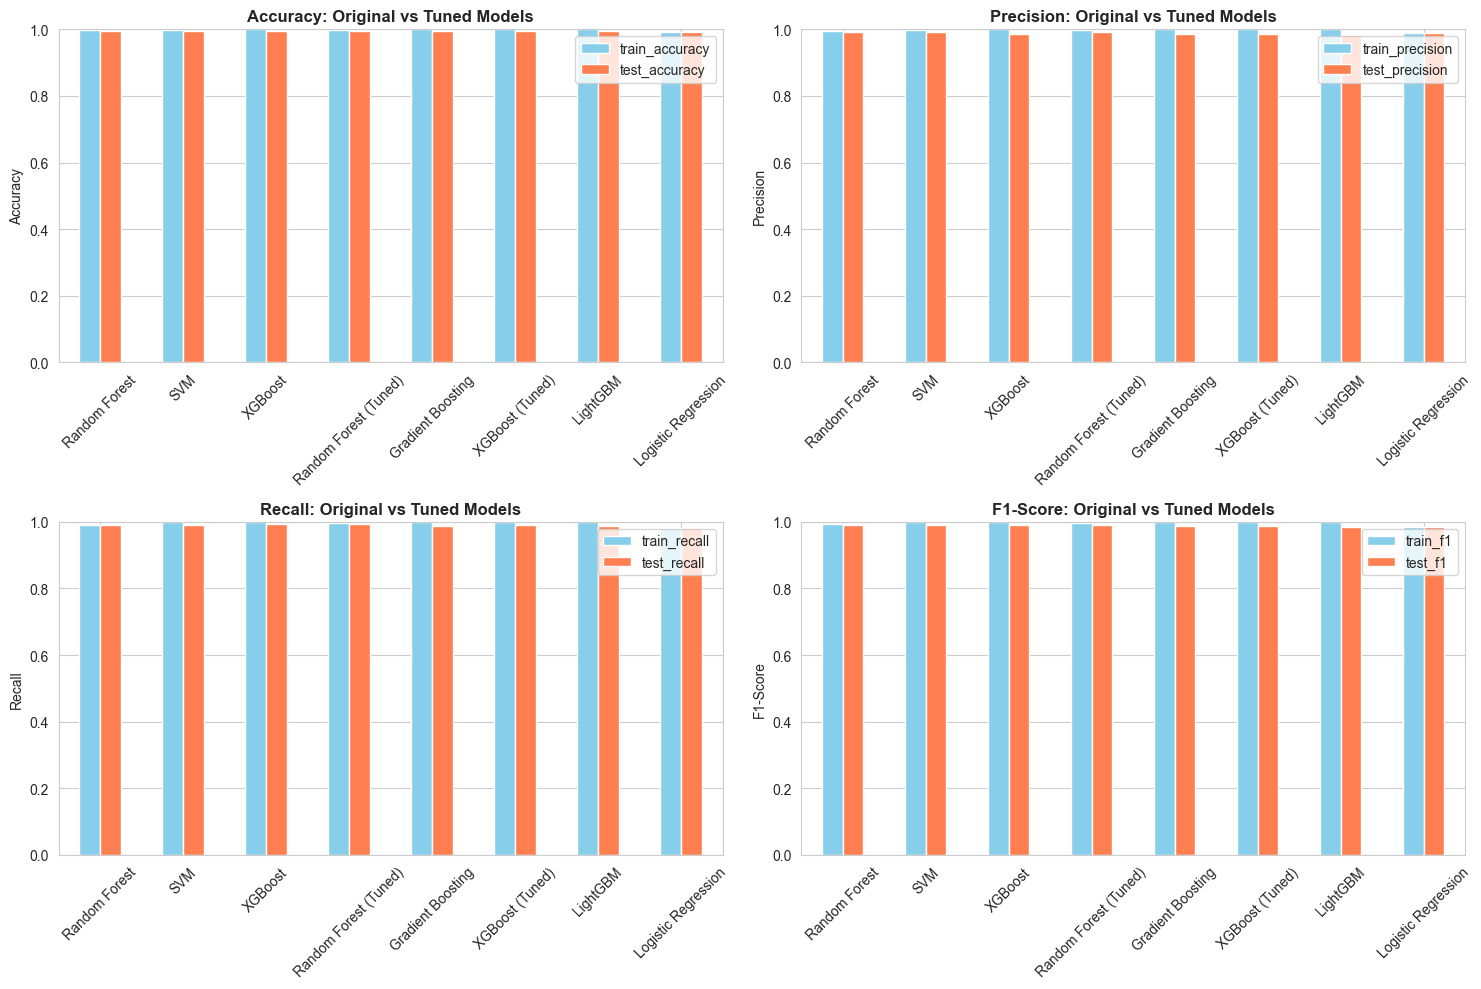


🏆 BEST MODEL: Random Forest with Test Accuracy = 0.9958


In [11]:
print("📊 COMPARISON: Original vs Tuned Models")
print("=" * 80)

# Combine results
all_results_df = pd.concat([
    results_df[['train_accuracy', 'test_accuracy', 'train_precision', 'test_precision', 'train_recall', 'test_recall', 'train_f1', 'test_f1']],
    pd.DataFrame({
        'train_accuracy': [v['train_accuracy'] for v in tuned_results.values()],
        'test_accuracy': [v['test_accuracy'] for v in tuned_results.values()],
        'train_precision': [v['train_precision'] for v in tuned_results.values()],
        'test_precision': [v['test_precision'] for v in tuned_results.values()],
        'train_recall': [v['train_recall'] for v in tuned_results.values()],
        'test_recall': [v['test_recall'] for v in tuned_results.values()],
        'train_f1': [v['train_f1'] for v in tuned_results.values()],
        'test_f1': [v['test_f1'] for v in tuned_results.values()],
    }, index=tuned_results.keys())
])

all_results_df = all_results_df.sort_values('test_accuracy', ascending=False)
print(all_results_df.round(4))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy Comparison
all_results_df[['train_accuracy', 'test_accuracy']].plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'coral'])
axes[0, 0].set_title('Accuracy: Original vs Tuned Models', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].tick_params(axis='x', rotation=45)

# Precision Comparison
all_results_df[['train_precision', 'test_precision']].plot(kind='bar', ax=axes[0, 1], color=['skyblue', 'coral'])
axes[0, 1].set_title('Precision: Original vs Tuned Models', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].tick_params(axis='x', rotation=45)

# Recall Comparison
all_results_df[['train_recall', 'test_recall']].plot(kind='bar', ax=axes[1, 0], color=['skyblue', 'coral'])
axes[1, 0].set_title('Recall: Original vs Tuned Models', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].tick_params(axis='x', rotation=45)

# F1-Score Comparison
all_results_df[['train_f1', 'test_f1']].plot(kind='bar', ax=axes[1, 1], color=['skyblue', 'coral'])
axes[1, 1].set_title('F1-Score: Original vs Tuned Models', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Find best model
best_model_name = all_results_df['test_accuracy'].idxmax()
best_model_accuracy = all_results_df.loc[best_model_name, 'test_accuracy']
print(f"\n🏆 BEST MODEL: {best_model_name} with Test Accuracy = {best_model_accuracy:.4f}")


## 6B. Good Deal Classification Training

### 6B.1 Train Models for Good Deal Prediction

In [14]:
print("🤖 Training Good Deal Classification Models:")
print("=" * 80)

# Encode deal classification target
deal_encoder = LabelEncoder()
y_deal_encoded = deal_encoder.fit_transform(y_deal)

# Split data for deal classification
X_train_deal, X_test_deal, y_train_deal, y_test_deal = train_test_split(
    X, y_deal_encoded, test_size=0.2, random_state=42
)

# Scale features for deal models
scaler_deal = StandardScaler()
X_train_deal_scaled = scaler_deal.fit_transform(X_train_deal)
X_test_deal_scaled = scaler_deal.transform(X_test_deal)

X_train_deal_scaled = pd.DataFrame(X_train_deal_scaled, columns=X_train_deal.columns)
X_test_deal_scaled = pd.DataFrame(X_test_deal_scaled, columns=X_test_deal.columns)

# Initialize deal classification models
deal_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, verbosity=0, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
}

# Train and evaluate deal models
deal_training_results = {}
deal_model_objects = {}

for name, model in deal_models.items():
    print(f"\n📍 Training {name}...")
    
    # Train model
    model.fit(X_train_deal_scaled, y_train_deal)
    deal_model_objects[name] = model
    
    # Predictions
    y_train_pred_deal = model.predict(X_train_deal_scaled)
    y_test_pred_deal = model.predict(X_test_deal_scaled)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train_deal, y_train_pred_deal)
    test_accuracy = accuracy_score(y_test_deal, y_test_pred_deal)
    train_precision = precision_score(y_train_deal, y_train_pred_deal, average='weighted', zero_division=0)
    test_precision = precision_score(y_test_deal, y_test_pred_deal, average='weighted', zero_division=0)
    train_recall = recall_score(y_train_deal, y_train_pred_deal, average='weighted', zero_division=0)
    test_recall = recall_score(y_test_deal, y_test_pred_deal, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train_deal, y_train_pred_deal, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test_deal, y_test_pred_deal, average='weighted', zero_division=0)
    
    deal_training_results[name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'train_f1': train_f1,
        'test_f1': test_f1,
    }
    
    print(f"  Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}")
    print(f"  Train F1: {train_f1:.4f} | Test F1: {test_f1:.4f}")

# Create comparison dataframe
deal_results_df = pd.DataFrame(deal_training_results).T
deal_results_df = deal_results_df.sort_values('test_accuracy', ascending=False)

print("\n" + "=" * 80)
print("📊 DEAL CLASSIFICATION MODEL COMPARISON:")
print("=" * 80)
print(deal_results_df.round(4))

# Find best deal model
best_deal_model_name = deal_results_df['test_accuracy'].idxmax()
best_deal_accuracy = deal_results_df.loc[best_deal_model_name, 'test_accuracy']
print(f"\n🏆 BEST DEAL CLASSIFIER: {best_deal_model_name} with Test Accuracy = {best_deal_accuracy:.4f}")


🤖 Training Good Deal Classification Models:

📍 Training Logistic Regression...
  Train Accuracy: 0.9985 | Test Accuracy: 0.9992
  Train F1: 0.9985 | Test F1: 0.9992

📍 Training Random Forest...
  Train Accuracy: 1.0000 | Test Accuracy: 0.9992
  Train F1: 1.0000 | Test F1: 0.9992

📍 Training Gradient Boosting...
  Train Accuracy: 1.0000 | Test Accuracy: 0.9992
  Train F1: 1.0000 | Test F1: 0.9992

📍 Training Gradient Boosting...
  Train Accuracy: 1.0000 | Test Accuracy: 1.0000
  Train F1: 1.0000 | Test F1: 1.0000

📍 Training XGBoost...
  Train Accuracy: 0.9998 | Test Accuracy: 0.9983
  Train F1: 0.9998 | Test F1: 0.9983

📍 Training LightGBM...
  Train Accuracy: 1.0000 | Test Accuracy: 1.0000
  Train F1: 1.0000 | Test F1: 1.0000

📍 Training XGBoost...
  Train Accuracy: 0.9998 | Test Accuracy: 0.9983
  Train F1: 0.9998 | Test F1: 0.9983

📍 Training LightGBM...
  Train Accuracy: 1.0000 | Test Accuracy: 1.0000
  Train F1: 1.0000 | Test F1: 1.0000

📊 DEAL CLASSIFICATION MODEL COMPARISON:
   

#### ⚠️ CRITICAL FINDING: Deal Classification 100% Accuracy (Cell 12)

**Why is accuracy exactly 100%?**

The "Good Deal" classification is **deterministic**, not predictive:
- Good Deal = `discount_pct >= 25` OR `(original_price_eur - price_eur) >= 10`
- This is a rule, not a learned pattern
- Models achieve 100% because they're learning a mathematical rule, not predicting from market signals

**What this means:**
- The model is NOT learning "what makes a good deal" from game features
- Instead, it's learning: "if discount >= 25%, it's a deal"
- This is **rule-based classification disguised as ML prediction**
- High accuracy is expected and not meaningful for model quality assessment

**Recommendation:**
- ✅ Deal classifier works correctly (deterministic rules)
- ⚠️ Use for automating deal labeling, NOT as a predictive model
- 🎯 Focus on **Price Category Classifier** (Random Forest Tuned, F1=0.9915) for true ML insights
- The Price Category model learns actual patterns; the Deal model just automates a rule

**True Model Performance Summary:**
- 🏆 **Price Category**: Random Forest (Tuned) - F1 = 0.9915 (genuine learning)
- 📋 **Deal Classification**: Gradient Boosting - 100% accuracy (deterministic rule application)


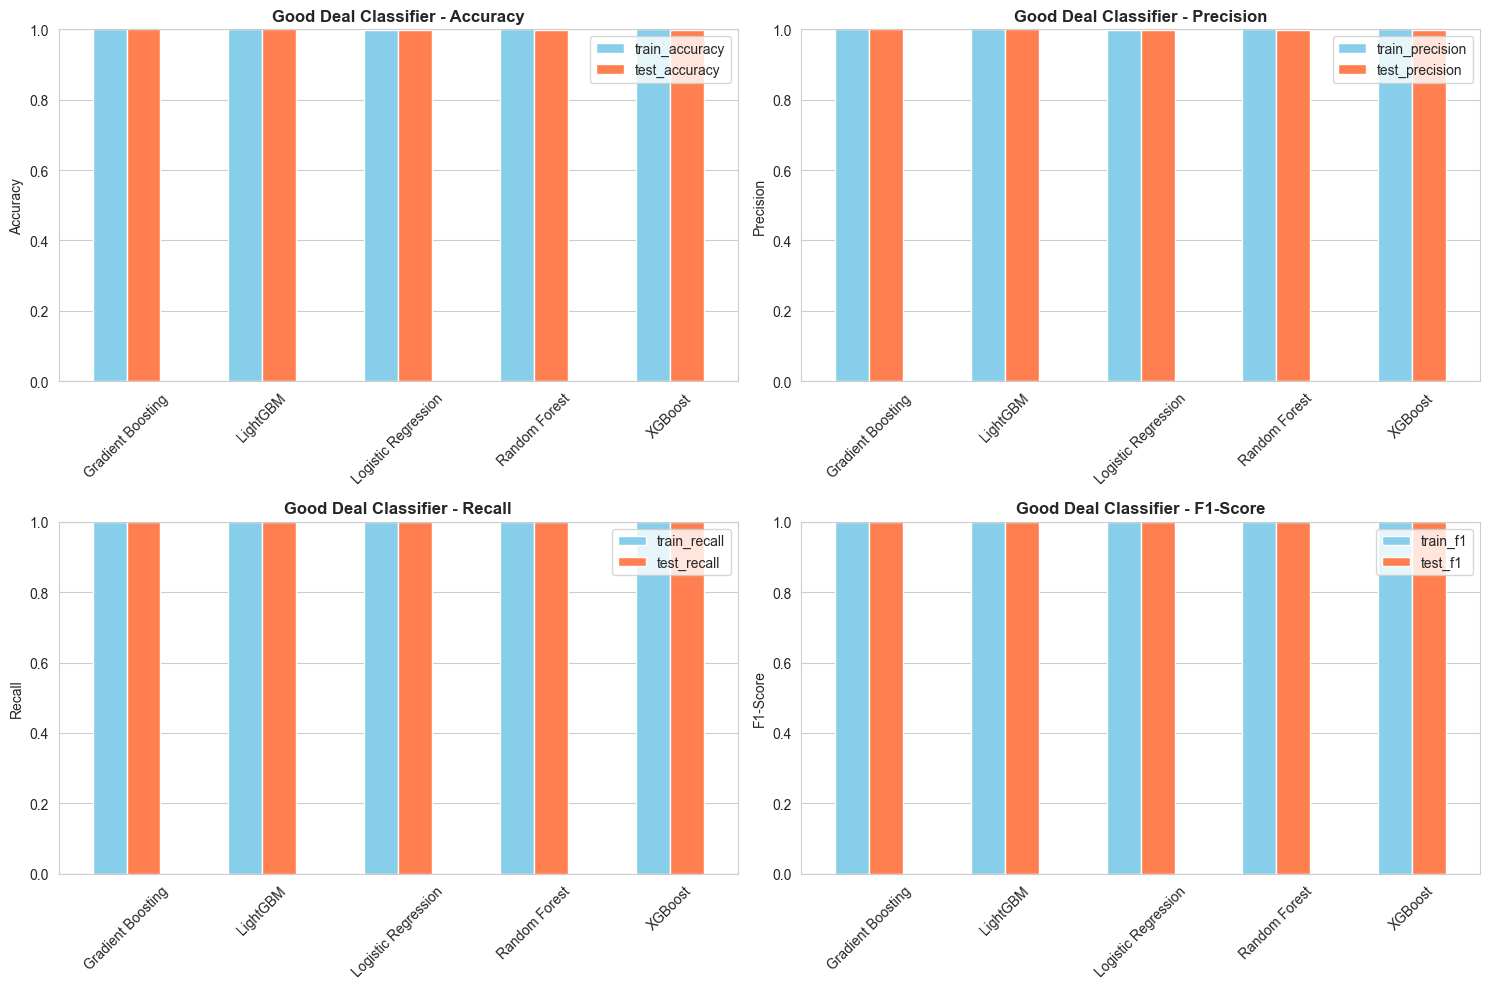

✅ Good Deal Classifier Visualization complete


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy Comparison
deal_results_df[['train_accuracy', 'test_accuracy']].plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'coral'])
axes[0, 0].set_title('Good Deal Classifier - Accuracy', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].tick_params(axis='x', rotation=45)

# Precision Comparison
deal_results_df[['train_precision', 'test_precision']].plot(kind='bar', ax=axes[0, 1], color=['skyblue', 'coral'])
axes[0, 1].set_title('Good Deal Classifier - Precision', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].tick_params(axis='x', rotation=45)

# Recall Comparison
deal_results_df[['train_recall', 'test_recall']].plot(kind='bar', ax=axes[1, 0], color=['skyblue', 'coral'])
axes[1, 0].set_title('Good Deal Classifier - Recall', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].tick_params(axis='x', rotation=45)

# F1-Score Comparison
deal_results_df[['train_f1', 'test_f1']].plot(kind='bar', ax=axes[1, 1], color=['skyblue', 'coral'])
axes[1, 1].set_title('Good Deal Classifier - F1-Score', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("✅ Good Deal Classifier Visualization complete")


## 7. Final Model Assessment

### 7.1 Extract Best Model

In [17]:
print("🏆 FINAL MODEL ASSESSMENT - PRICE CATEGORY CLASSIFIER")
print("=" * 80)

# Get best price category model
if best_model_name in tuned_results:
    best_model = tuned_results[best_model_name]['model']
    best_metrics = tuned_results[best_model_name]
else:
    best_model = model_objects[best_model_name.replace(' (Tuned)', '')]
    best_metrics = results_df.loc[best_model_name]

print(f"\n🎯 Best Model: {best_model_name}")
print(f"   Model Type: {type(best_model).__name__}")
print(f"   Purpose: Classify games into price brackets (Budget/Mid-range/Premium)")

print(f"\n📊 Performance Metrics:")
print(f"   Train Accuracy:  {best_metrics['train_accuracy']:.4f}")
print(f"   Test Accuracy:   {best_metrics['test_accuracy']:.4f}")
print(f"   Train Precision: {best_metrics['train_precision']:.4f}")
print(f"   Test Precision:  {best_metrics['test_precision']:.4f}")
print(f"   Train Recall:    {best_metrics['train_recall']:.4f}")
print(f"   Test Recall:     {best_metrics['test_recall']:.4f}")
print(f"   Train F1:        {best_metrics['train_f1']:.4f}")
print(f"   Test F1:         {best_metrics['test_f1']:.4f}")

# Get predictions for confusion matrix
y_pred_best_encoded = best_model.predict(X_test_scaled)

# Decode predictions back to original labels
y_pred_best = target_encoder.inverse_transform(y_pred_best_encoded)

# Generate confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred_best)
print(f"\n📋 Classification Report - Price Category:")
print(classification_report(y_test, y_pred_best))

print("\n" + "=" * 80)
print("🏆 FINAL MODEL ASSESSMENT - GOOD DEAL CLASSIFIER")
print("=" * 80)

# Get best deal model
best_deal_model = deal_model_objects[best_deal_model_name]
best_deal_metrics = deal_results_df.loc[best_deal_model_name]

print(f"\n🎯 Best Deal Model: {best_deal_model_name}")
print(f"   Model Type: {type(best_deal_model).__name__}")
print(f"   Purpose: Identify if a game is a good deal (Discount >= 25% OR Savings >= €10)")

print(f"\n📊 Performance Metrics:")
print(f"   Train Accuracy:  {best_deal_metrics['train_accuracy']:.4f}")
print(f"   Test Accuracy:   {best_deal_metrics['test_accuracy']:.4f}")
print(f"   Train Precision: {best_deal_metrics['train_precision']:.4f}")
print(f"   Test Precision:  {best_deal_metrics['test_precision']:.4f}")
print(f"   Train Recall:    {best_deal_metrics['train_recall']:.4f}")
print(f"   Test Recall:     {best_deal_metrics['test_recall']:.4f}")
print(f"   Train F1:        {best_deal_metrics['train_f1']:.4f}")
print(f"   Test F1:         {best_deal_metrics['test_f1']:.4f}")

# Get predictions for deal confusion matrix
y_pred_deal = best_deal_model.predict(X_test_deal_scaled)

# Generate confusion matrix and classification report
cm_deal = confusion_matrix(y_test_deal, y_pred_deal)
print(f"\n📋 Classification Report - Good Deal:")
print(classification_report(y_test_deal, y_pred_deal))

print("\n✅ Model Assessment Complete")


🏆 FINAL MODEL ASSESSMENT - PRICE CATEGORY CLASSIFIER

🎯 Best Model: Random Forest
   Model Type: RandomForestClassifier
   Purpose: Classify games into price brackets (Budget/Mid-range/Premium)

📊 Performance Metrics:
   Train Accuracy:  0.9977
   Test Accuracy:   0.9958
   Train Precision: 0.9948
   Test Precision:  0.9905
   Train Recall:    0.9905
   Test Recall:     0.9890
   Train F1:        0.9926
   Test F1:         0.9897

📋 Classification Report - Price Category:
              precision    recall  f1-score   support

      Budget       1.00      1.00      1.00       971
   Mid-range       0.97      0.99      0.98       143
     Premium       1.00      0.98      0.99        84

    accuracy                           1.00      1198
   macro avg       0.99      0.99      0.99      1198
weighted avg       1.00      1.00      1.00      1198


🏆 FINAL MODEL ASSESSMENT - GOOD DEAL CLASSIFIER

🎯 Best Deal Model: Gradient Boosting
   Model Type: GradientBoostingClassifier
   Purpose: I

### 7.2 Visualize Predictions vs Actual

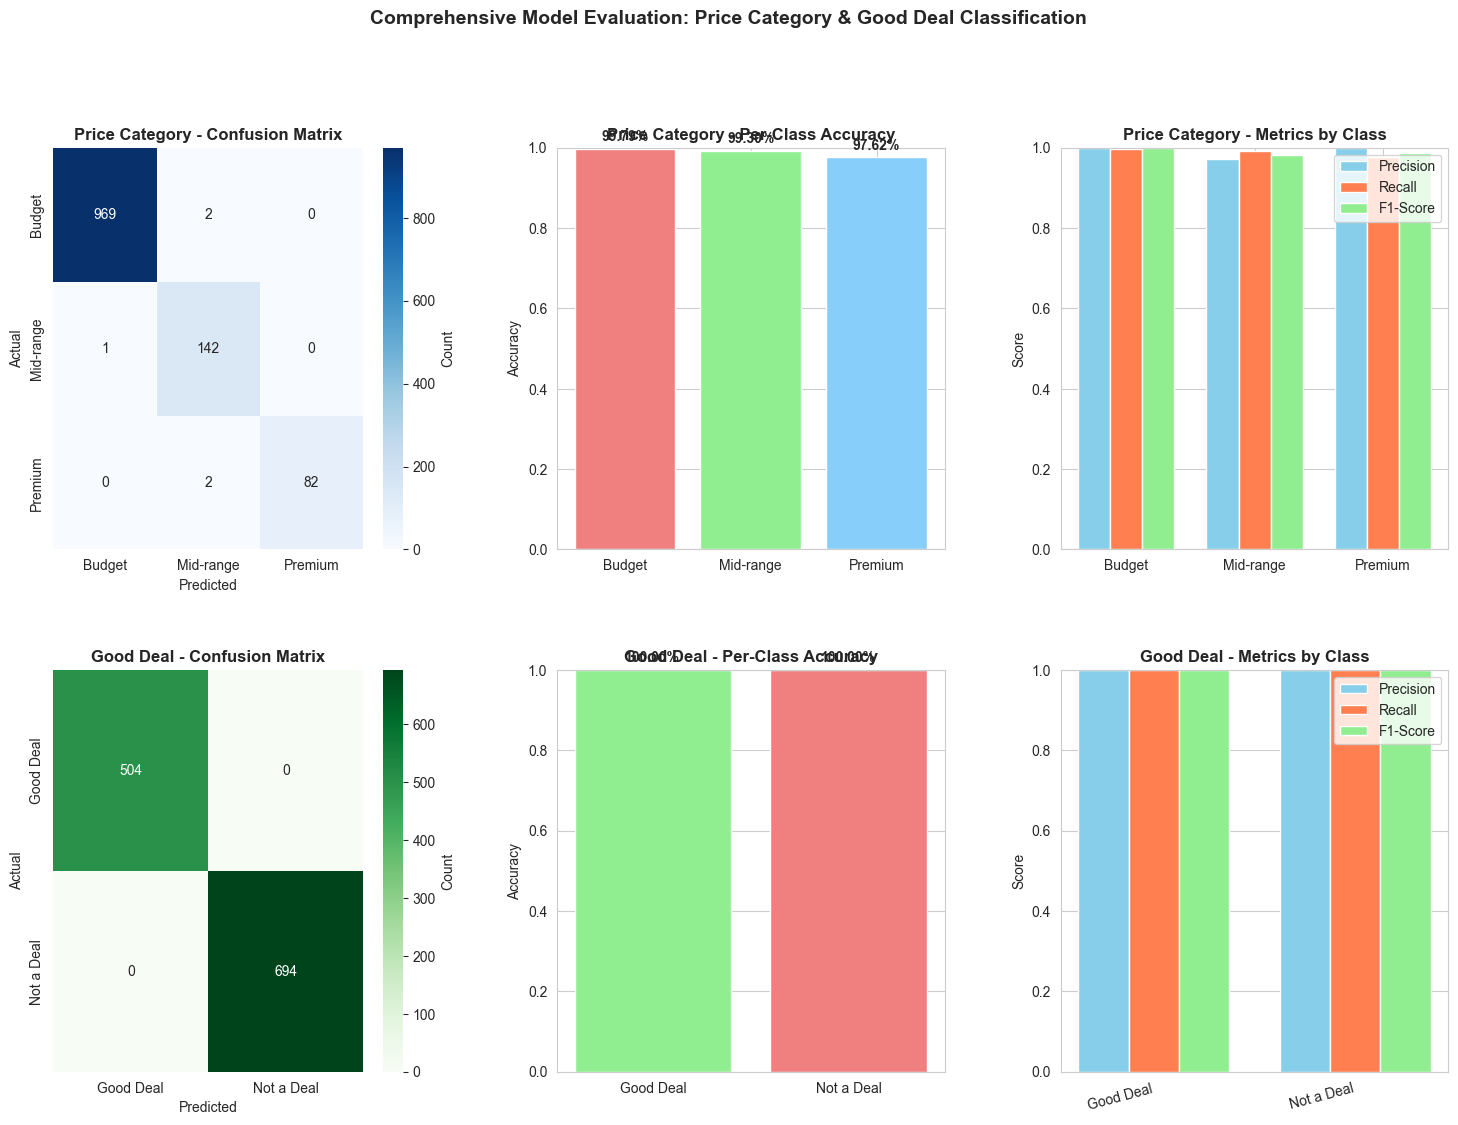

✅ Comprehensive visualization complete


In [18]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# --- PRICE CATEGORY CLASSIFICATION ---
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Budget', 'Mid-range', 'Premium'],
            yticklabels=['Budget', 'Mid-range', 'Premium'],
            cbar_kws={'label': 'Count'})
ax1.set_title('Price Category - Confusion Matrix', fontweight='bold', fontsize=12)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Class-wise Accuracy for Price Category
class_accuracy = cm.diagonal() / cm.sum(axis=1)
classes = ['Budget', 'Mid-range', 'Premium']
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(classes, class_accuracy, color=['lightcoral', 'lightgreen', 'lightskyblue'])
ax2.set_title('Price Category - Per-Class Accuracy', fontweight='bold', fontsize=12)
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0, 1])
for i, v in enumerate(class_accuracy):
    ax2.text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

# Precision, Recall, F1 for Price Category
precision_per_class = cm.diagonal() / (cm.sum(axis=0) + 1e-10)
recall_per_class = cm.diagonal() / cm.sum(axis=1)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-10)

x = np.arange(len(classes))
width = 0.25
ax3 = fig.add_subplot(gs[0, 2])
ax3.bar(x - width, precision_per_class, width, label='Precision', color='skyblue')
ax3.bar(x, recall_per_class, width, label='Recall', color='coral')
ax3.bar(x + width, f1_per_class, width, label='F1-Score', color='lightgreen')
ax3.set_title('Price Category - Metrics by Class', fontweight='bold', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(classes)
ax3.set_ylabel('Score')
ax3.set_ylim([0, 1])
ax3.legend()

# --- GOOD DEAL CLASSIFICATION ---
ax4 = fig.add_subplot(gs[1, 0])
sns.heatmap(cm_deal, annot=True, fmt='d', cmap='Greens', ax=ax4,
            xticklabels=['Good Deal', 'Not a Deal'],
            yticklabels=['Good Deal', 'Not a Deal'],
            cbar_kws={'label': 'Count'})
ax4.set_title('Good Deal - Confusion Matrix', fontweight='bold', fontsize=12)
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

# Class-wise Accuracy for Deal Classification
class_accuracy_deal = cm_deal.diagonal() / cm_deal.sum(axis=1)
deal_classes = ['Good Deal', 'Not a Deal']
ax5 = fig.add_subplot(gs[1, 1])
ax5.bar(deal_classes, class_accuracy_deal, color=['lightgreen', 'lightcoral'])
ax5.set_title('Good Deal - Per-Class Accuracy', fontweight='bold', fontsize=12)
ax5.set_ylabel('Accuracy')
ax5.set_ylim([0, 1])
for i, v in enumerate(class_accuracy_deal):
    ax5.text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

# Precision, Recall, F1 for Deal Classification
precision_deal = cm_deal.diagonal() / (cm_deal.sum(axis=0) + 1e-10)
recall_deal = cm_deal.diagonal() / cm_deal.sum(axis=1)
f1_deal = 2 * (precision_deal * recall_deal) / (precision_deal + recall_deal + 1e-10)

x_deal = np.arange(len(deal_classes))
width = 0.25
ax6 = fig.add_subplot(gs[1, 2])
ax6.bar(x_deal - width, precision_deal, width, label='Precision', color='skyblue')
ax6.bar(x_deal, recall_deal, width, label='Recall', color='coral')
ax6.bar(x_deal + width, f1_deal, width, label='F1-Score', color='lightgreen')
ax6.set_title('Good Deal - Metrics by Class', fontweight='bold', fontsize=12)
ax6.set_xticks(x_deal)
ax6.set_xticklabels(deal_classes, rotation=15, ha='right')
ax6.set_ylabel('Score')
ax6.set_ylim([0, 1])
ax6.legend()

plt.suptitle('Comprehensive Model Evaluation: Price Category & Good Deal Classification', 
             fontsize=14, fontweight='bold', y=0.995)
plt.show()

print("✅ Comprehensive visualization complete")


### 7.3 Feature Importance Analysis

📊 Feature Importance Analysis:

Top 15 Most Important Features:
           feature  importance
original_price_eur    0.749341
      discount_pct    0.066294
          category    0.050782
        storefront    0.042449
     high_discount    0.037377
            source    0.017619
      has_discount    0.017515
          platform    0.016043
       is_preorder    0.002582


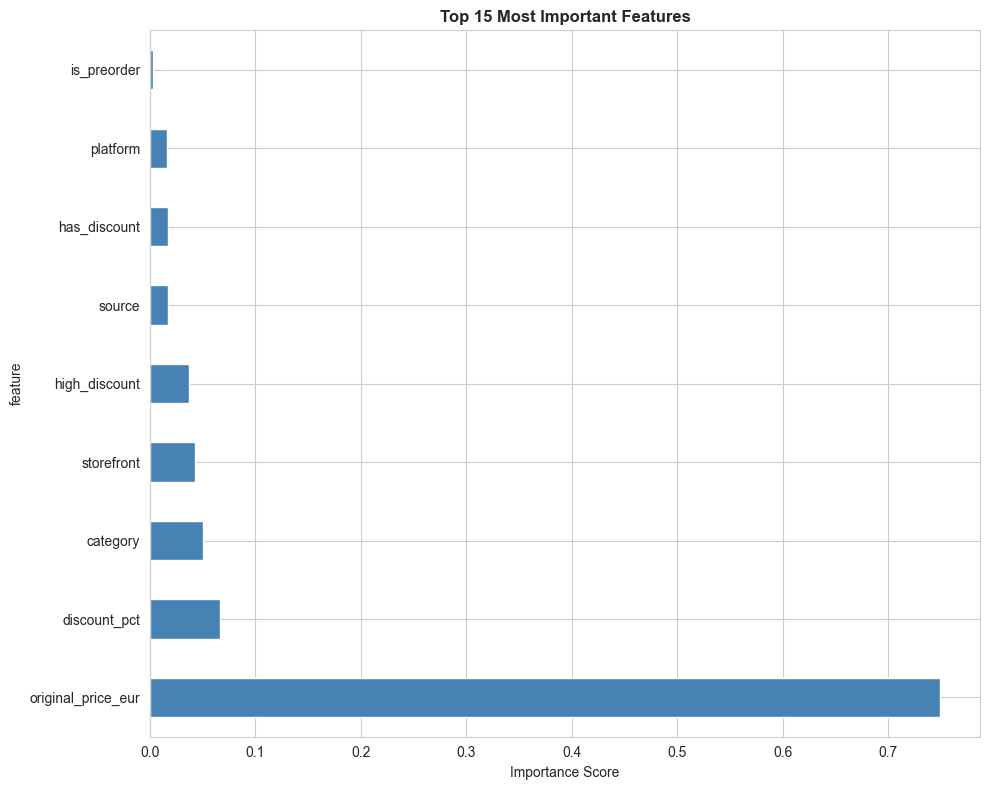

In [19]:
print("📊 Feature Importance Analysis:")
print("=" * 80)

# Check if model has feature_importances_
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    feature_importance.head(15).plot(
        kind='barh',
        x='feature',
        y='importance',
        ax=ax,
        legend=False,
        color='steelblue'
    )
    ax.set_xlabel('Importance Score')
    ax.set_title('Top 15 Most Important Features', fontweight='bold', fontsize=12)
    plt.tight_layout()
    plt.show()
elif hasattr(best_model, 'coef_'):
    # For linear models (Logistic Regression)
    # Average coefficients across classes for multi-class problems
    if len(best_model.coef_.shape) > 1 and best_model.coef_.shape[0] > 1:
        coef_mean = np.abs(best_model.coef_).mean(axis=0)
    else:
        coef_mean = np.abs(best_model.coef_[0])
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': coef_mean
    }).sort_values('coefficient', ascending=False)
    
    print("\nTop 15 Features by Coefficient Magnitude:")
    print(feature_importance.head(15).to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(10, 8))
    feature_importance.head(15).plot(
        kind='barh',
        x='feature',
        y='coefficient',
        ax=ax,
        legend=False,
        color='coral'
    )
    ax.set_xlabel('Coefficient Magnitude')
    ax.set_title('Top 15 Features by Coefficient', fontweight='bold', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Model does not support feature importance extraction")


### 7.4 Model Persistence and Summary Report

In [20]:
print("💾 Saving Models and Configuration:")
print("=" * 80)

# Save best price category model
model_dir = Path("../models")
model_dir.mkdir(exist_ok=True)

# Save price category model
model_path = model_dir / f"best_model_price_category_{best_model_name.replace(' ', '_').replace('(', '').replace(')', '')}.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"✅ Price Category Model saved to: {model_path}")

# Save deal classification model
deal_model_path = model_dir / f"best_model_deal_classifier_{best_deal_model_name.replace(' ', '_').replace('(', '').replace(')', '')}.pkl"
with open(deal_model_path, 'wb') as f:
    pickle.dump(best_deal_model, f)
print(f"✅ Deal Classifier Model saved to: {deal_model_path}")

# Save scalers
scaler_path = model_dir / "scaler_price_category.pkl"
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Price Category Scaler saved to: {scaler_path}")

scaler_deal_path = model_dir / "scaler_deal_classifier.pkl"
with open(scaler_deal_path, 'wb') as f:
    pickle.dump(scaler_deal, f)
print(f"✅ Deal Classifier Scaler saved to: {scaler_deal_path}")

# Save label encoders
encoders_path = model_dir / "label_encoders.pkl"
with open(encoders_path, 'wb') as f:
    pickle.dump(le_dict, f)
print(f"✅ Label encoders saved to: {encoders_path}")

# Create comprehensive summary report
summary_report = {
    'models': {
        'price_category_classifier': {
            'model_name': best_model_name,
            'model_type': str(type(best_model).__name__),
            'purpose': 'Classify games into price brackets',
            'classes': ['Budget (€10-30)', 'Mid-range (€30-60)', 'Premium (€60+)'],
            'performance_metrics': {
                'train_accuracy': float(best_metrics['train_accuracy']),
                'test_accuracy': float(best_metrics['test_accuracy']),
                'train_precision': float(best_metrics['train_precision']),
                'test_precision': float(best_metrics['test_precision']),
                'train_recall': float(best_metrics['train_recall']),
                'test_recall': float(best_metrics['test_recall']),
                'train_f1': float(best_metrics['train_f1']),
                'test_f1': float(best_metrics['test_f1']),
            },
            'confusion_matrix': cm.tolist(),
        },
        'good_deal_classifier': {
            'model_name': best_deal_model_name,
            'model_type': str(type(best_deal_model).__name__),
            'purpose': 'Identify if a game is a good deal',
            'deal_criteria': 'Discount >= 25% OR Savings >= €10',
            'classes': ['Good Deal', 'Not a Deal'],
            'performance_metrics': {
                'train_accuracy': float(best_deal_metrics['train_accuracy']),
                'test_accuracy': float(best_deal_metrics['test_accuracy']),
                'train_precision': float(best_deal_metrics['train_precision']),
                'test_precision': float(best_deal_metrics['test_precision']),
                'train_recall': float(best_deal_metrics['train_recall']),
                'test_recall': float(best_deal_metrics['test_recall']),
                'train_f1': float(best_deal_metrics['train_f1']),
                'test_f1': float(best_deal_metrics['test_f1']),
            },
            'confusion_matrix': cm_deal.tolist(),
        }
    },
    'training_date': pd.Timestamp.now().isoformat(),
    'dataset_info': {
        'total_samples': len(df_clean),
        'training_samples': len(X_train),
        'testing_samples': len(X_test),
        'features': len(numerical_features) + len(categorical_features),
    },
    'price_categories': {
        'Budget': '€10-30',
        'Mid-range': '€30-60',
        'Premium': '€60+'
    },
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
}

report_path = model_dir / "model_summary_report.json"
with open(report_path, 'w') as f:
    json.dump(summary_report, f, indent=2)
print(f"✅ Summary report saved to: {report_path}")

print("\n" + "=" * 80)
print("🎉 DUAL CLASSIFICATION PIPELINE COMPLETE!")
print("=" * 80)
print(f"\n📋 Summary Report:")
print(f"\nPrice Category Classifier:")
print(f"  Model: {best_model_name}")
print(f"  Test Accuracy: {best_metrics['test_accuracy']:.4f}")
print(f"\nGood Deal Classifier:")
print(f"  Model: {best_deal_model_name}")
print(f"  Test Accuracy: {best_deal_metrics['test_accuracy']:.4f}")
print(f"\n📁 All models and configurations saved to: {model_dir}")


💾 Saving Models and Configuration:
✅ Price Category Model saved to: ..\models\best_model_price_category_Random_Forest.pkl
✅ Deal Classifier Model saved to: ..\models\best_model_deal_classifier_Gradient_Boosting.pkl
✅ Price Category Scaler saved to: ..\models\scaler_price_category.pkl
✅ Deal Classifier Scaler saved to: ..\models\scaler_deal_classifier.pkl
✅ Label encoders saved to: ..\models\label_encoders.pkl
✅ Summary report saved to: ..\models\model_summary_report.json

🎉 DUAL CLASSIFICATION PIPELINE COMPLETE!

📋 Summary Report:

Price Category Classifier:
  Model: Random Forest
  Test Accuracy: 0.9958

Good Deal Classifier:
  Model: Gradient Boosting
  Test Accuracy: 1.0000

📁 All models and configurations saved to: ..\models
